In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import time
from tqdm.notebook import tqdm

from proteolizarddata.data import PyTimsDataHandle, TimsFrame, MzSpectrum
from proteolizardalgo.hashing import TimsHasher, IsotopeReferenceSearch, ReferencePattern
from proteolizardalgo.utility import create_reference_dict, get_refspec_list, get_ref_pattern_as_spectra

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KDTree

In [2]:
dh = PyTimsDataHandle('../../../data/M210115_001_Slot1-1_1_850.d/')
selected_ions = dh.get_selected_precursors()

In [3]:
def match_patterns_with_vendor_selected(mz_bins, scans, tmp_patterns, allowed_distance=5):
    
    is_overlapping = (np.sign(mz_bins) - 1) / (-2)
    
    range_start = WINDOW_LENGTH * np.abs(mz_bins) - is_overlapping * (WINDOW_LENGTH / 2) 
    range_stop = range_start + WINDOW_LENGTH
    
    as_frame = pd.DataFrame({'mz_start': range_start, 'mz_stop': range_stop,
                             'mz_mid': range_start + WINDOW_LENGTH / 2,
                             'scan_start': scans - 7, 'scan_stop': scans + 7,
                             'scan_mid': scans})
    
    
    tmp_patterns['scan'] = np.round(tmp_patterns.ScanNumber.values, 1)
    tmp_patterns['mz'] = np.round(tmp_patterns.MonoisotopicMz.values, 2)

    tmp_patterns = tmp_patterns[['Parent', 'mz', 'scan']]

    kdt = KDTree(as_frame[['scan_mid', 'mz_mid']].values, leaf_size=30, metric='manhattan')
    distance, index = kdt.query(tmp_patterns[['scan', 'mz']].values)

    matched = pd.DataFrame(np.hstack((np.squeeze(as_frame.values[index]), 
                                      tmp_patterns.values, distance)), columns=['mz_start',
                                                                                'mz_stop',
                                                                                'mz_mid',
                                                                                'scan_start',
                                                                                'scan_stop',  
                                                                                'scan_mid',
                                                                                'Parent', 
                                                                                'mz', 
                                                                                'scan',
                                                                                'distance'])

    matched['mz_diff'] = np.abs(matched.mz_mid - matched.mz)
    matched['scan_diff'] = np.abs(matched.scan_mid - matched.scan)

    fetched = matched[matched.distance <= allowed_distance]
    not_fetched = matched[matched.distance > allowed_distance]

    return fetched, not_fetched

In [4]:
selected_ions

,Id,LargestPeakMz,AverageMz,MonoisotopicMz,Charge,ScanNumber,Intensity,Parent
0,1,850.791519,851.254552,850.791519,1.0,431.214477,3042.0,1
1,2,749.893834,750.174519,749.893834,1.0,481.389706,3016.0,1
2,3,640.883152,641.137708,640.883152,1.0,532.168868,9070.0,1
3,4,574.293780,574.581787,574.293780,2.0,666.702309,8978.0,1
4,5,459.255707,459.502542,459.255707,2.0,738.705002,5193.0,1
...,...,...,...,...,...,...,...,...
159750,159751,622.025454,622.025454,NaN,NaN,580.739867,3415.0,63813
159751,159752,1221.987656,1222.591240,1221.987656,1.0,226.036453,3825.0,63842
159752,159753,622.028638,622.283194,622.028638,1.0,581.280292,2905.0,63842
159753,159754,922.008974,922.489243,922.008974,1.0,402.424060,2870.0,63890


In [5]:
frames = [dh.get_frame(f) for f in np.random.choice(selected_ions.Parent.values[1500:], 50)]

In [6]:
WINDOW_LENGTH = 10
RESOLUTION = 1

N = np.linspace(16,32,num=8).astype(np.int16)
M = np.linspace(16,80,num=10).astype(np.int16)

In [7]:
N,M

(array([16, 18, 20, 22, 25, 27, 29, 32], dtype=int16),
 array([16, 23, 30, 37, 44, 51, 58, 65, 72, 80], dtype=int16))

In [8]:
num_n = N.shape[0]
num_m = M.shape[0]
num_n,num_m

(8, 10)

In [9]:
FETCHED = np.zeros((num_n, num_m))
REDUCED = np.zeros((num_n, num_m))

In [10]:
for i, n in tqdm(enumerate(N), total=num_n):
    
    for j, m in enumerate(M):
        
        hasher = TimsHasher(trials=m, len_trial=n, num_dalton=WINDOW_LENGTH, resolution=RESOLUTION)
        
        rate_list, reduction_list = [], []
        
        for frame in frames:
            
            f = frame.frame_id()
            
            tmp_patterns = selected_ions[selected_ions.Parent == f]
            tmp_patterns = tmp_patterns.dropna()
            
            if tmp_patterns.shape[0] != 0:
                
                s, b, W = frame.get_dense_windows(window_length=WINDOW_LENGTH, resolution=RESOLUTION, 
                                                  overlapping=True, min_intensity=25)
                K = hasher.calculate_keys(W)
                
                total_data = len(b)
                
                mz_bins, scans = hasher.calculate_collisions(K, s, b)
                
                filtered_data = len(mz_bins)
                
                fetched, not_fetched = match_patterns_with_vendor_selected(mz_bins, scans, tmp_patterns)
                fetch_rate = fetched.shape[0] / (fetched.shape[0] + not_fetched.shape[0])
                
                rate_list.append(fetch_rate)
                tmp_red_value = 1 - filtered_data / total_data
                reduction_list.append(tmp_red_value)
        
        if len(rate_list) != 0:
            FETCHED[i, j] = np.round(np.mean(rate_list), 3)
            REDUCED[i, j] = np.round(np.mean(reduction_list), 3)

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
# Plot settings ---------------------------------------
widthMM = 170 
widthInch = widthMM / 25.4
ratio = 0.66666
heigthInch = ratio*widthInch

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")

dpi = 300

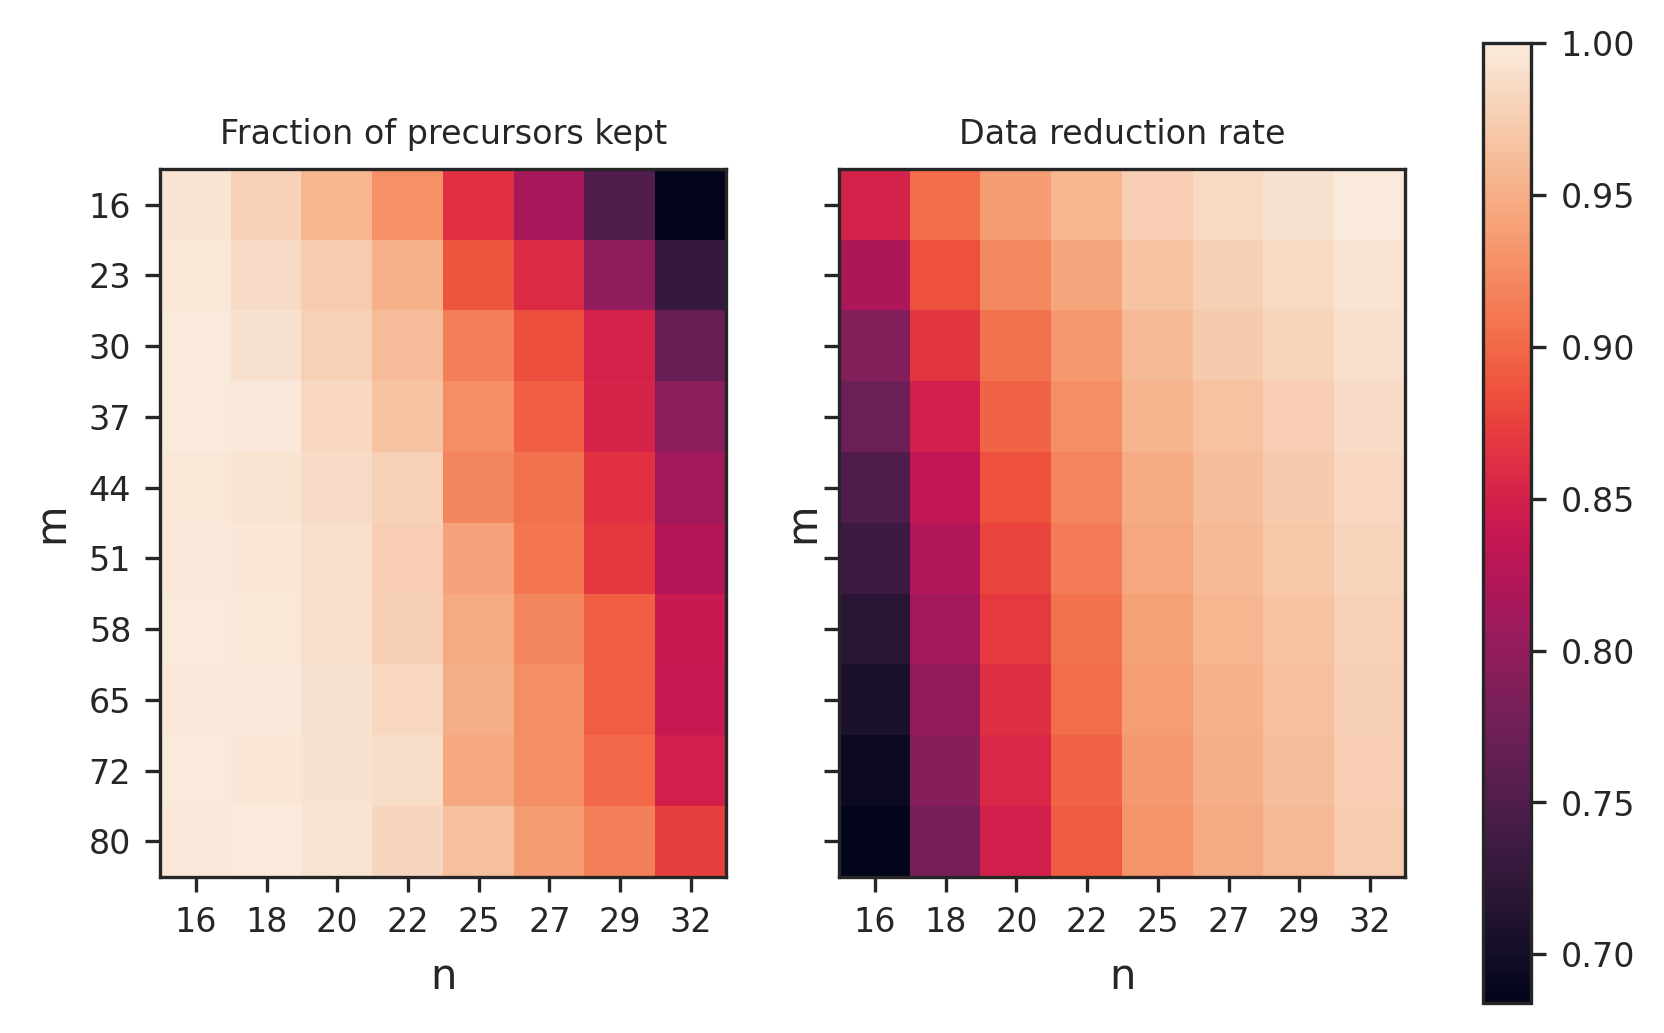

In [12]:
fig, ax = plt.subplots(1,2,figsize=(widthInch, heigthInch),dpi=dpi,sharey=True)

ax[0].title.set_text('Fraction of precursors kept')
im = ax[0].imshow(FETCHED.T)
ax[0].set_ylabel('m')
ax[0].set_xlabel('n')

plt.sca(ax[0])
plt.xticks(range(num_n), [n for n in N])
plt.yticks(range(num_m), [m for m in M])


ax[1].title.set_text('Data reduction rate')
ax[1].imshow(REDUCED.T)
ax[1].set_ylabel('m')
ax[1].set_xlabel('n')

plt.sca(ax[1])
plt.xticks(range(num_n), [n for n in N])
plt.yticks(range(num_m), [m for m in M])

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
       
plt.savefig("../../../plots/evaluation_big.pdf",dpi=dpi)

plt.show()